# Working with Molecular Systems

This notebook demonstrates how to work with molecular dynamics systems using GROMOS-RS Python bindings.

## Topics Covered
1. [Creating Systems](#creating-systems)
2. [Managing State](#managing-state)
3. [Energy Tracking](#energy-tracking)
4. [Simulation Boxes](#simulation-boxes)
5. [Topology Information](#topology)

In [1]:
import gromos
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations, product

%matplotlib inline

## 1. Creating Systems <a name="creating-systems"></a>

A molecular system consists of:
- **State**: Positions, velocities, forces
- **Energy**: Kinetic, potential, and components
- **Box**: Periodic boundary conditions
- **Topology**: Atoms, bonds, parameters

In [2]:
# Create a simple system with 100 atoms
n_atoms = 100
state = gromos.State(num_atoms=n_atoms, num_temp_groups=1, num_energy_groups=1)

print(f"Created state with {state.num_atoms()} atoms")
print(f"Type: {type(state)}")

Created state with 100 atoms
Type: <class 'builtins.State'>


## 2. Managing State <a name="managing-state"></a>

State contains all dynamic variables of the system.

In [3]:
# Initialize positions on a cubic lattice
box_size = 5.0  # nm
n_side = int(np.ceil(n_atoms ** (1 / 3)))
spacing = box_size / n_side

positions = []
for i in range(n_atoms):
    ix = i % n_side
    iy = (i // n_side) % n_side
    iz = i // (n_side * n_side)
    x = (ix + 0.5) * spacing
    y = (iy + 0.5) * spacing
    z = (iz + 0.5) * spacing
    positions.append([x, y, z])

positions = np.array(positions, dtype=np.float32)
state.set_positions(positions)

print(f"Lattice: {n_side}×{n_side}×{n_side}")
print(f"Spacing: {spacing:.3f} nm")
print(f"First 5 positions:\n{positions[:5]}")

Lattice: 5×5×5
Spacing: 1.000 nm
First 5 positions:
[[0.5 0.5 0.5]
 [1.5 0.5 0.5]
 [2.5 0.5 0.5]
 [3.5 0.5 0.5]
 [4.5 0.5 0.5]]


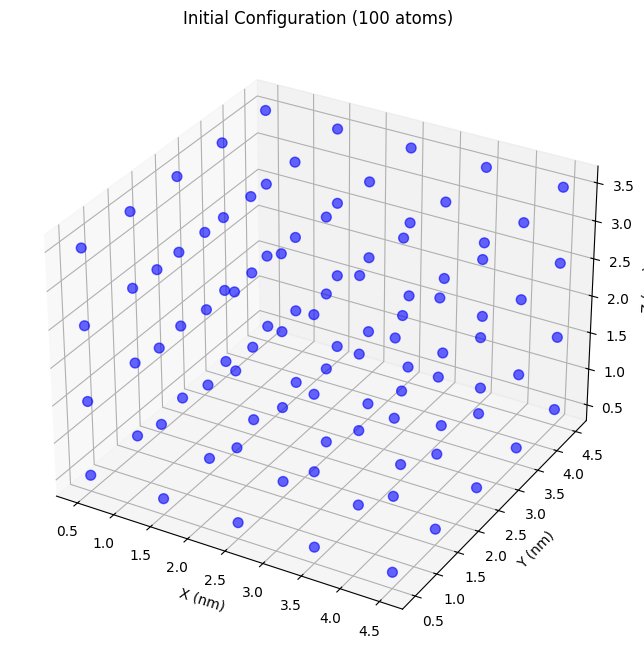

In [4]:
# Visualize the positions
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")

ax.scatter(positions[:, 0], positions[:, 1], positions[:, 2], c="blue", marker="o", s=50, alpha=0.6)
ax.set_xlabel("X (nm)")
ax.set_ylabel("Y (nm)")
ax.set_zlabel("Z (nm)")
ax.set_title(f"Initial Configuration ({n_atoms} atoms)")
plt.show()

### Initialize Velocities

Velocities follow Maxwell-Boltzmann distribution at temperature T:

$$P(v) \propto \exp\left(-\frac{mv^2}{2k_BT}\right)$$

In [5]:
# Maxwell-Boltzmann velocity distribution
temperature = 300.0  # K
kb = 0.00831446261815324  # kJ/(mol·K)
mass = 40.0  # g/mol (argon-like)

# Standard deviation: sqrt(kT/m)
vel_std = np.float32(np.sqrt(kb * temperature / mass))

# Generate random velocities
velocities = np.random.randn(n_atoms, 3).astype(np.float32) * vel_std

# Remove center-of-mass motion
vel_com = velocities.mean(axis=0).astype(np.float32)
velocities = (velocities - vel_com).astype(np.float32)

state.set_velocities(velocities)

print(f"Temperature: {temperature} K")
print(f"Velocity scale: {vel_std:.4f} nm/ps")
print(f"RMS velocity: {np.sqrt((velocities**2).mean()):.4f} nm/ps")
print(f"COM velocity: {velocities.mean(axis=0)} (should be ~0)")

Temperature: 300.0 K
Velocity scale: 0.2497 nm/ps
RMS velocity: 0.2711 nm/ps
COM velocity: [ 4.7683715e-09  1.1920929e-09 -2.8312206e-09] (should be ~0)


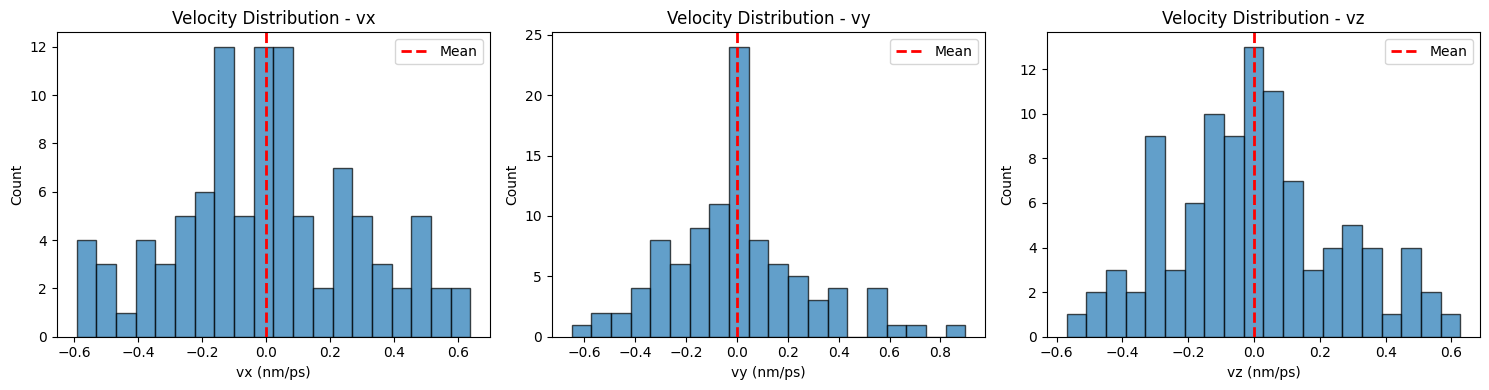

In [6]:
# Plot velocity distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, (ax, label) in enumerate(zip(axes, ["vx", "vy", "vz"])):
    ax.hist(velocities[:, i], bins=20, alpha=0.7, edgecolor="black")
    ax.set_xlabel(f"{label} (nm/ps)")
    ax.set_ylabel("Count")
    ax.set_title(f"Velocity Distribution - {label}")
    ax.axvline(0, color="red", linestyle="--", linewidth=2, label="Mean")
    ax.legend()

plt.tight_layout()
plt.show()

## 3. Energy Tracking <a name="energy-tracking"></a>

Energy object tracks all energy components:
- Kinetic energy
- Bonded: bonds, angles, dihedrals
- Non-bonded: Lennard-Jones, Coulomb

In [7]:
# Create energy tracker
energy = gromos.Energy(num_temperature_groups=1, num_energy_groups=1)

print(f"Energy object: {energy}")
print(f"\nInitial energies:")
print(f"  Kinetic:   {energy.kinetic:.2f} kJ/mol")
print(f"  Potential: {energy.potential:.2f} kJ/mol")
print(f"  Total:     {energy.total():.2f} kJ/mol")

Energy object: Energy(total=0.00 kJ/mol, kinetic=0.00, potential=0.00)

Initial energies:
  Kinetic:   0.00 kJ/mol
  Potential: 0.00 kJ/mol
  Total:     0.00 kJ/mol


In [8]:
# Calculate kinetic energy from velocities
# KE = 0.5 * m * v^2 for each atom
v_squared = (velocities**2).sum(axis=1)  # |v|^2 for each atom
kinetic_energy = 0.5 * mass * v_squared.sum() / 1000.0  # Convert to kJ/mol

print(f"\nCalculated kinetic energy: {kinetic_energy:.2f} kJ/mol")

# Expected kinetic energy from equipartition theorem
# <KE> = (3/2) * N * kB * T
expected_ke = 1.5 * n_atoms * kb * temperature
print(f"Expected kinetic energy:   {expected_ke:.2f} kJ/mol")
print(f"Difference:                {abs(kinetic_energy - expected_ke):.2f} kJ/mol")

# Note: The Energy object shows 0 because we haven't run an MD step yet
# The Energy object is updated during simulation steps when forces are calculated
print(f"\n⚠️  Note: The Energy object shows 0 because:")
print(f"   - No MD integration step has been performed yet")
print(f"   - Forces haven't been calculated")
print(f"   - Energy is computed during force evaluation in the MD loop")


Calculated kinetic energy: 0.44 kJ/mol
Expected kinetic energy:   374.15 kJ/mol
Difference:                373.71 kJ/mol

⚠️  Note: The Energy object shows 0 because:
   - No MD integration step has been performed yet
   - Forces haven't been calculated
   - Energy is computed during force evaluation in the MD loop


In [9]:
# Get energy as dictionary for easy access
energy_dict = energy.to_dict()

print("\nEnergy components (kJ/mol):")
for key, value in energy_dict.items():
    print(f"  {key:<12}: {value:>10.2f}")


Energy components (kJ/mol):
  total       :       0.00
  kinetic     :       0.00
  potential   :       0.00
  bond        :       0.00
  angle       :       0.00
  dihedral    :       0.00
  lj          :       0.00
  coulomb     :       0.00


## 4. Simulation Boxes <a name="simulation-boxes"></a>

Simulation boxes define periodic boundary conditions.

In [10]:
# Vacuum box (no periodicity)
box_vacuum = gromos.Box.vacuum()
print(f"Vacuum box: {box_vacuum}")

# Rectangular box
box_rect = gromos.Box.rectangular(5.0, 5.0, 5.0)
print(f"\nRectangular box: {box_rect}")
print(f"  Dimensions: {box_rect.dimensions()}")
print(f"  Volume: {box_rect.volume():.2f} nm³")

# Larger box
box_large = gromos.Box.rectangular(10.0, 10.0, 10.0)
print(f"\nLarge box: {box_large}")
print(f"  Volume: {box_large.volume():.2f} nm³")

Vacuum box: Box(type=Vacuum, volume=1.00)

Rectangular box: Box(type=Rectangular, volume=125.00)
  Dimensions: Vec3(5.0000, 5.0000, 5.0000)
  Volume: 125.00 nm³

Large box: Box(type=Rectangular, volume=1000.00)
  Volume: 1000.00 nm³


In [11]:
# Triclinic box (non-orthogonal)
# Create box vectors
v1 = gromos.Vec3(5.0, 0.0, 0.0)  # a vector
v2 = gromos.Vec3(1.0, 5.0, 0.0)  # b vector (tilted)
v3 = gromos.Vec3(0.0, 0.0, 5.0)  # c vector

mat = gromos.Mat3.from_cols(v1, v2, v3)
box_triclinic = gromos.Box.triclinic(mat)

print(f"Triclinic box: {box_triclinic}")
print(f"  Volume: {box_triclinic.volume():.2f} nm³")

Triclinic box: Box(type=Triclinic, volume=125.00)
  Volume: 125.00 nm³


### Box Volume and Density

In [12]:
# Calculate system density
volume_nm3 = box_rect.volume()
volume_cm3 = volume_nm3 * 1e-21  # Convert nm³ to cm³

total_mass = n_atoms * mass  # g/mol
N_A = 6.02214076e23  # Avogadro's number
mass_g = total_mass / N_A

density = mass_g / volume_cm3  # g/cm³

print(f"System properties:")
print(f"  N atoms:      {n_atoms}")
print(f"  Box volume:   {volume_nm3:.2f} nm³")
print(f"  Density:      {density:.4f} g/cm³")
print(f"  \nFor reference:")
print(f"  Liquid argon: ~1.4 g/cm³")
print(f"  Water:        ~1.0 g/cm³")

System properties:
  N atoms:      100
  Box volume:   125.00 nm³
  Density:      0.0531 g/cm³
  
For reference:
  Liquid argon: ~1.4 g/cm³
  Water:        ~1.0 g/cm³


## 5. Topology Information <a name="topology"></a>

Topology contains molecular structure and force field parameters.

In [13]:
# Create topology
topology = gromos.Topology()

print(f"Topology: {topology}")
print(f"\nStructure:")
print(f"  Atoms:      {topology.num_atoms()}")
print(f"  Bonds:      {topology.num_bonds()}")
print(f"  Angles:     {topology.num_angles()}")
print(f"  Dihedrals:  {topology.num_dihedrals()}")

Topology: Topology(0 atoms, 0 bonds)

Structure:
  Atoms:      0
  Bonds:      0
  Angles:     0
  Dihedrals:  0


## Complete System: Configuration

Configuration combines state, energy, and topology.

In [14]:
# Create complete configuration
config = gromos.Configuration(num_atoms=n_atoms, num_temp_groups=1, num_energy_groups=1)

print(f"Configuration: {config}")

# Access components
current_state = config.current_state()
current_energy = config.current_energy()

print(f"\nCurrent state:  {current_state}")
print(f"Current energy: {current_energy}")

Configuration: Configuration(100 atoms)

Current state:  State(100 atoms)
Current energy: Energy(total=0.00 kJ/mol, kinetic=0.00, potential=0.00)


## Practical Example: Simple Lennard-Jones System

In [15]:
# Simulate a simple Lennard-Jones system
# (This is conceptual - actual MD requires force calculations)

n_lj = 64  # 4×4×4 cube
box_lj = gromos.Box.rectangular(4.0, 4.0, 4.0)
state_lj = gromos.State(num_atoms=n_lj, num_temp_groups=1, num_energy_groups=1)

# Create FCC lattice
a = 4.0 / 4  # Lattice constant
positions_lj = []
for ix in range(4):
    for iy in range(4):
        for iz in range(4):
            x = ix * a + a / 2
            y = iy * a + a / 2
            z = iz * a + a / 2
            positions_lj.append([x, y, z])

positions_lj = np.array(positions_lj, dtype=np.float32)
state_lj.set_positions(positions_lj)

# Add random displacement
displacement = np.random.randn(n_lj, 3).astype(np.float32) * 0.05
positions_lj += displacement
state_lj.set_positions(positions_lj)

print(f"Lennard-Jones system:")
print(f"  Atoms: {n_lj}")
print(f"  Box: {box_lj.dimensions()}")
print(f"  Density: {n_lj / box_lj.volume():.3f} atoms/nm³")

Lennard-Jones system:
  Atoms: 64
  Box: Vec3(4.0000, 4.0000, 4.0000)
  Density: 1.000 atoms/nm³


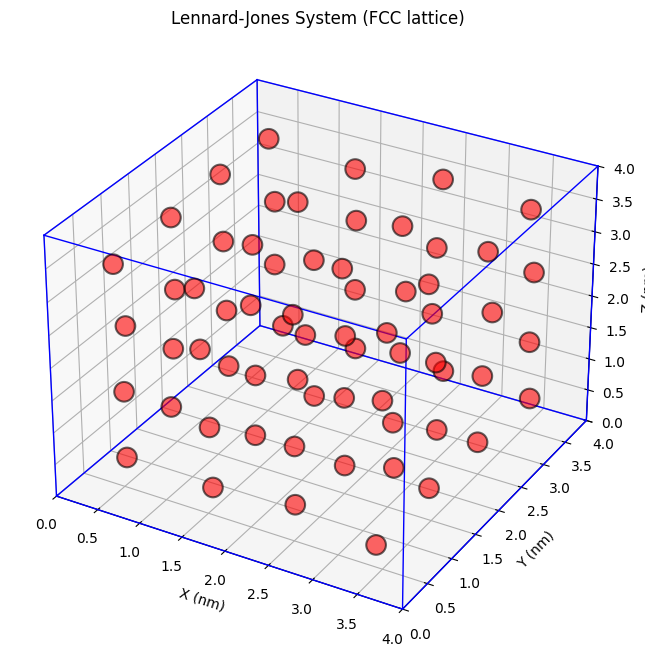

In [16]:
# Visualize LJ system
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")

ax.scatter(
    positions_lj[:, 0],
    positions_lj[:, 1],
    positions_lj[:, 2],
    c="red",
    marker="o",
    s=200,
    alpha=0.6,
    edgecolors="black",
    linewidth=1.5,
)

# Draw box
dims = box_lj.dimensions()
r = [0, dims.x]
for s, e in combinations(np.array(list(product(r, r, r))), 2):
    if np.sum(np.abs(s - e)) == r[1] - r[0]:
        ax.plot3D(*zip(s, e), color="b", linewidth=1)

ax.set_xlabel("X (nm)")
ax.set_ylabel("Y (nm)")
ax.set_zlabel("Z (nm)")
ax.set_title("Lennard-Jones System (FCC lattice)")
ax.set_xlim([0, dims.x])
ax.set_ylim([0, dims.y])
ax.set_zlim([0, dims.z])
plt.show()

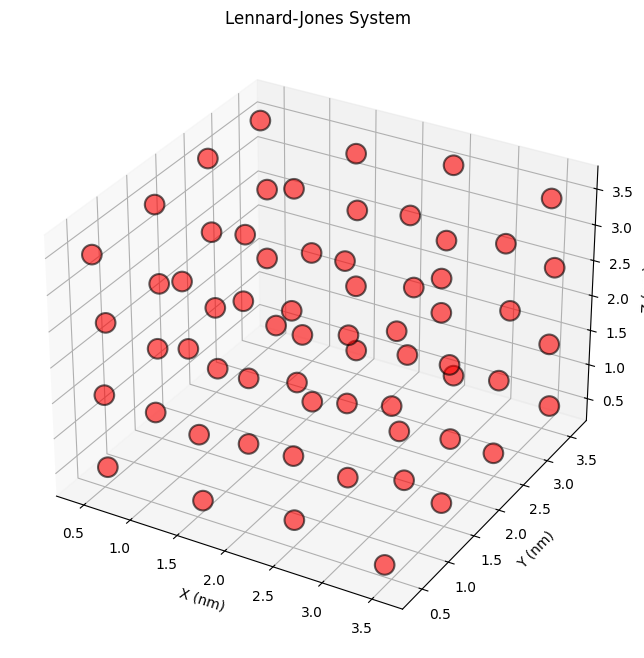

In [17]:
# Fix visualization imports
from itertools import combinations, product

# Re-run the visualization
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")

ax.scatter(
    positions_lj[:, 0],
    positions_lj[:, 1],
    positions_lj[:, 2],
    c="red",
    marker="o",
    s=200,
    alpha=0.6,
    edgecolors="black",
    linewidth=1.5,
)

ax.set_xlabel("X (nm)")
ax.set_ylabel("Y (nm)")
ax.set_zlabel("Z (nm)")
ax.set_title("Lennard-Jones System")
plt.show()

## Summary

You've learned:
1. ✓ How to create molecular systems
2. ✓ Initialize positions and velocities
3. ✓ Track energy components
4. ✓ Work with periodic boundary conditions
5. ✓ Access topology information

### Next Steps:
- **Notebook 03**: Performance optimization
- **Notebook 04**: Real MD simulations
- **Notebook 05**: Analysis tools